In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interpn

xx=np.linspace(-3,3,50)
yy=np.linspace(-3,3,50)
zz=np.linspace(-3,3,50)
xX,yY,zZ=np.meshgrid(xx,yy,zz) #set up grid to plot function on
mat=np.exp(-(xX**2+yY**2+zZ**2)) #plot the function
m1=xX**3+yY**3+zZ**3

In [97]:
class visualize:
    """
    this class allows for a variety of methods to visualize the calculated 3Dmpdf. Requires both the 3Dmpdf
    array and the 3 arrays x, y, z from which the grid was created.
        
    """
        
    def __init__(self, m, x, y, z):
        self.m = m
        self.x = x
        self.y = y
        self.z = z
    
    def make_slice(self, side_len=1, res=20, p1=np.array([0,1,0]), p2=np.array([1,0,0]), 
                   p3=np.array([0,0,1]), contour=True):
        
        """credit to Alex Shaw for code that creates the desired plane
        
        Args:
        
            side_len: the side length of the square slice to be taken through the data
            res: resolution of our grid. Determines how many measurements per 1 unit length
            cen_pt: the center of our grid (1D numpy array of 3 values)
            norm_vec: determines the orientation of the plane, which is orthogonal to norm_vec (1D numpy array of 3 values)
            circular: If True, will plot a circular slice rather than square, where side_len becomes radius
            
        Returns:
        
            Plots the desired slice through the input 3Dmpdf array

        """
        #first find norm_vec from three points given
        #find two vectors from the three points which lie on the desired plane
        vec1 = p2 - p1
        vec2 = p3 - p1
        #now cross these two vectors to find a vector normal to the plane
        norm_vec = np.cross(vec1,vec2)
    
        #now calculate the centroid of the three points given
        x_pos = (p1[0]+p2[0]+p3[0])/3
        y_pos = (p1[1]+p2[1]+p3[1])/3
        z_pos = (p1[2]+p2[2]+p3[2])/3
        cen_pt = np.array([x_pos,y_pos,z_pos])
        print(cen_pt)
        #ensure that our basis vector v1 is not the same as norm_vec
        v1 = np.array([1,0,0])
        if np.allclose(v1, norm_vec):
            v1 = np.array([0,1,0])
    
        #now make a matrix which will reflect any vector onto the orthogonal
        #complement of norm_vec, which is our desired plane
        m_norm = np.eye(3) - (np.outer(norm_vec, norm_vec.T) / norm_vec.T.dot(norm_vec))
    
        #now reflect v1 using m_norm
        v1 = m_norm.dot(v1)
        #and create a new vector v2 that is orthogonal to both v1 and norm_vec
        v2 = np.cross(norm_vec,v1)
    
        #we now have 2 vectors to form our plane
    
        #now create and normalize Q, which will transition our slice to
        #our desired plane
        Q = np.column_stack((v1, v2, np.zeros_like(v1)))
        Q[:,:2] /= np.linalg.norm(Q[:,:2], axis=0)
    
        #create an arbitrary grid
        a = np.linspace(-side_len/2, side_len/2, res*side_len)
        b = np.linspace(-side_len/2, side_len/2, res*side_len)
    
        A,B = np.meshgrid(a,b)
        
        locations = np.array([A.reshape(-1), B.reshape(-1), np.zeros(A.size)])
        
        #now move locations onto our two vectors
        locations = Q.dot(locations).T+(cen_pt)
    
        #now we need to interpolate our 3Dmpdf function over this slice
        points = (self.x,self.y,self.z)
        interp = interpn(points, self.m, locations)
        square_slice = interp.reshape(len(a),len(b))
        if contour == True:
            plt.contourf(a,b,square_slice,cmap=cm.jet)
            plt.colorbar()
        else:
            plt.imshow(square_slice, cmap=cm.jet, origin='lower', extent=[xx.min()/2, xx.max()/2, yy.min()/2, yy.max()/2])
            plt.colorbar()
            plt.show()
    
    def cut_portion(self, p1=[0,0,0], p2=[0,0,1], orien=0):
        
        """
        Args:
        
            p1, p2: the desired plane is orthogonal to the normal vector p2 - p1.
            orien: determines which portion to keep. Enter 0 for above the plane, 1 for below
        
        Returns:
            
            Array containing all points on the designated plane, and all points either above or below this plane
        """
        
        grid = np.zeros((len(self.x),len(self.y),len(self.z))) #3D grid to hold sliced values
        if orien != 0 and orien != 1:
            print('Invalid value entered for orien. Choose an integer (0 = portion below plane, 1 = portion above plane)')
            return
        vec_n = p2 - p1; #create our normal vector
        for i in range((np.shape(self.m))[0]):
            for j in range((np.shape(self.m))[1]):
                for k in range((np.shape(self.m))[2]):
                    p3 = np.array([self.x[i],self.y[j],self.z[k]]) #take each point x,y,z on meshgrid
                    vec_t = p3 - p1 #vector describing the test point
                    dot = np.sum(vec_n*vec_t,0) #dot product of two vectors
                    if orien == 0:
                        if dot <= 0:
                            grid[i,j,k] = self.m[i][j][k] + grid[i][j][k] #record value if on or below plane
                    else:
                        if dot >= 0:
                            grid[i,j,k] = self.m[i][j][k] + grid[i][j][k] #record value if on or above plane
                        
        return grid
    
    
    def convert_1D(self):
        
        """
        takes XX,YY,ZZ, defined from meshgrid(x,y,z), and converts the meshgrid to 1D
        returns a flattened 3D array m along with the corresponding distance from origin array r
        """
        
        XX, YY, ZZ = np.meshgrid(self.x,self.y,self.z)
        rarray=np.sqrt(XX**2+YY**2+ZZ**2) #make array of distances from origin r for each x,y,z point
        rarray1=np.ravel(rarray) #put into form to plot
        m1=np.ravel(self.m)
        plt.plot(rarray1,m1)

[-0.33333333  0.          0.33333333]


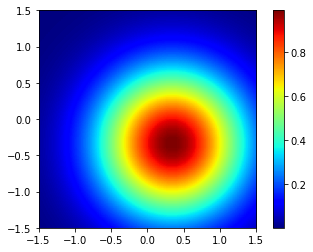

In [99]:
slice1=visualize(mat,xx,yy,zz)
slice1.make_slice(3,40,np.array([-1,0,0]),np.array([0,0,0]),np.array([0,0,1]),False)